# Wait for User Input

In [2]:
var userHomeDir = System.getProperty("user.home");
var localRespoUrl = "file://" + userHomeDir + "/.m2/repository/";
var langchain4jVersion = "1.0.1";
var langchain4jbeta = "1.0.1-beta6";
var langgraph4jVersion = "1.6-SNAPSHOT";

In [3]:
%%bash 
rm -rf \{userHomeDir}/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/bsc/langgraph4j

In [ ]:
%dependency /add-repo local \{localRespoUrl} release|never snapshot|always
// %dependency /list-repos
%dependency /add org.bsc.langgraph4j:langgraph4j-core:\{langgraph4jVersion}
%dependency /add org.bsc.langgraph4j:langgraph4j-langchain4j:\{langgraph4jVersion}
%dependency /add dev.langchain4j:langchain4j:\{langchain4jVersion}
// %dependency /add dev.langchain4j:langchain4j-open-ai:\{langchain4jVersion}
%dependency /add dev.langchain4j:langchain4j-ollama:\{langchain4jbeta}
%dependency /add net.sourceforge.plantuml:plantuml-mit:1.2024.6
%dependency /list-dependencies
%dependency /resolve

**utility to render graph respresentation in PlantUML**

In [5]:
import net.sourceforge.plantuml.SourceStringReader;
import net.sourceforge.plantuml.FileFormatOption;
import net.sourceforge.plantuml.FileFormat;
import org.bsc.langgraph4j.GraphRepresentation;

void displayDiagram( GraphRepresentation representation ) throws IOException { 
    
    var reader = new SourceStringReader(representation.getContent());

    try(var imageOutStream = new java.io.ByteArrayOutputStream()) {

        var description = reader.outputImage( imageOutStream, 0, new FileFormatOption(FileFormat.PNG));

        var imageInStream = new java.io.ByteArrayInputStream(  imageOutStream.toByteArray() );

        var image = javax.imageio.ImageIO.read( imageInStream );

        display(  image );

    }
}


## Define graph with interruption

SLF4J: No SLF4J providers were found.
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See https://www.slf4j.org/codes.html#noProviders for further details.


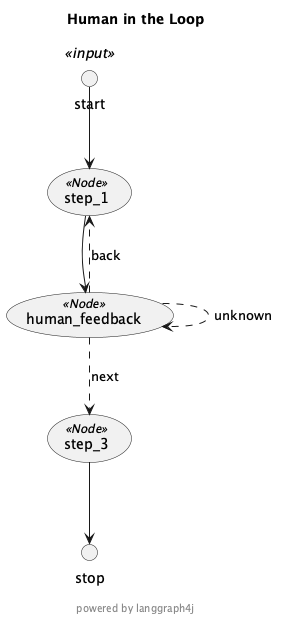

In [6]:
import org.bsc.langgraph4j.*;
import org.bsc.langgraph4j.prebuilt.MessagesState;
import org.bsc.langgraph4j.state.Channel;
import dev.langchain4j.data.message.AiMessage;
import dev.langchain4j.data.message.ChatMessage;
import org.bsc.langgraph4j.action.AsyncNodeAction;
import org.bsc.langgraph4j.action.AsyncEdgeAction;
import static org.bsc.langgraph4j.action.AsyncNodeAction.node_async;
import static org.bsc.langgraph4j.action.AsyncEdgeAction.edge_async;
import org.bsc.langgraph4j.checkpoint.MemorySaver;
import org.bsc.langgraph4j.CompileConfig;
import static org.bsc.langgraph4j.StateGraph.END;
import static org.bsc.langgraph4j.StateGraph.START;

public class State extends MessagesState<String> {

    public State(Map<String, Object> initData) {
        super( initData  );
    }

    public Optional<String> humanFeedback() {
        return value("human_feedback");
    }

}

AsyncNodeAction<State> step1 = node_async( state -> {
    return Map.of( "messages", "Step 1" );
});

AsyncNodeAction<State> humanFeedback = node_async( state -> {
    return Map.of();
});

AsyncNodeAction<State> step3 = node_async( state -> {
    return Map.of( "messages", "Step 3" );
});

AsyncEdgeAction<State> evalHumanFeedback = edge_async( state -> {
    var feedback = state.humanFeedback().orElseThrow();
    return ( feedback.equals("next") || feedback.equals("back") ) ? feedback : "unknown";
});

var builder = new StateGraph<>(State.SCHEMA, State::new)
    .addNode("step_1", step1)
    .addNode("human_feedback", humanFeedback)
    .addNode("step_3", step3)
    .addEdge(START, "step_1")
    .addEdge("step_1", "human_feedback")
    .addConditionalEdges("human_feedback", evalHumanFeedback, 
        Map.of( "back", "step_1", "next", "step_3", "unknown", "human_feedback" ))
    .addEdge("step_3", END)
    ;

// Set up memory
var saver = new MemorySaver();

// Add
var compileConfig = CompileConfig.builder()
                        .checkpointSaver(saver)
                        .interruptBefore("human_feedback")
                        .releaseThread(true)
                        .build();

var graph = builder.compile(compileConfig);


displayDiagram( graph.getGraph(GraphRepresentation.Type.PLANTUML, "Human in the Loop", false) );


## Start graph until interruption

In [7]:
// Input
Map<String,Object> initialInput = Map.of("messages", "Step 0");

// Thread
var invokeConfig = RunnableConfig.builder()
                        .threadId("Thread1")
                        .build();

// Run the graph until the first interruption
for (var event : graph.stream(initialInput, invokeConfig)) {
    System.out.println(event);
}


NodeOutput{node=__START__, state={messages=[Step 0]}}
NodeOutput{node=step_1, state={messages=[Step 0, Step 1]}}


## Wait for user input and update state

⚠️ The Java notebook, until now, doesn't support user input (take a look [issue #39](https://github.com/padreati/rapaio-jupyter-kernel/issues/39)) so we could simulate input ⚠️

In [8]:

// We can check the state
System.out.printf("--State before update--\n%s\n", graph.getState(invokeConfig));

// Simulate user input
var userInput = "back"; // back means we want to go back to the previous node
System.out.printf("\n--User Input--\nTell me how you want to update the state: '%s'\n\n", userInput);

// We now update the state as if we are the human_feedback node
var updateConfig = graph.updateState(invokeConfig, Map.of("human_feedback", userInput), null);

// We can check the state
System.out.printf("--State after update--\n%s\n", graph.getState(invokeConfig) );

// We can check the next node, showing that it is node 3 (which follows human_feedback)
System.out.printf("\ngetNext()\n\twith invokeConfig:[%s]\n\twith updateConfig:[%s]\n", 
            graph.getState(invokeConfig).getNext(),  
            graph.getState(updateConfig).getNext());
;

--State before update--
StateSnapshot{node=step_1, state={messages=[Step 0, Step 1]}, config=RunnableConfig{ threadId=Thread1, checkPointId=85b3831c-45b1-4e58-9016-c70bb130110b, nextNode=human_feedback, streamMode=VALUES }}

--User Input--
Tell me how you want to update the state: 'back'

--State after update--
StateSnapshot{node=step_1, state={messages=[Step 0, Step 1], human_feedback=back}, config=RunnableConfig{ threadId=Thread1, checkPointId=85b3831c-45b1-4e58-9016-c70bb130110b, nextNode=human_feedback, streamMode=VALUES }}

getNext()
	with invokeConfig:[human_feedback]
	with updateConfig:[human_feedback]


## Continue graph execution after interruption

In [9]:
// Continue the graph execution
for (var event : graph.stream(null, updateConfig)) {
    System.out.println(event);
}

NodeOutput{node=human_feedback, state={messages=[Step 0, Step 1], human_feedback=back}}
NodeOutput{node=step_1, state={messages=[Step 0, Step 1], human_feedback=back}}


## Waif for user input (again) and update state

⚠️ The Java notebook, until now, doesn't support user input (take a look [issue #39](https://github.com/padreati/rapaio-jupyter-kernel/issues/39)) so we could simulate input ⚠️

In [10]:
var userInput = "next"; // 'next' means we want to go to the next node
System.out.printf("\n--User Input--\nTell me how you want to update the state: '%s'\n", userInput);

// We now update the state as if we are the human_feedback node
var updateConfig = graph.updateState(invokeConfig, Map.of("human_feedback", userInput), null);

System.out.printf("\ngetNext()\n\twith invokeConfig:[%s]\n\twith updateConfig:[%s]\n", 
            graph.getState(invokeConfig).getNext(),  
            graph.getState(updateConfig).getNext());
            ;   



--User Input--
Tell me how you want to update the state: 'next'

getNext()
	with invokeConfig:[human_feedback]
	with updateConfig:[human_feedback]


## Continue graph execution after the 2nd interruption

In [11]:
// Continue the graph execution
for (var event : graph.stream(null, updateConfig)) {
    System.out.println(event);
}

NodeOutput{node=human_feedback, state={messages=[Step 0, Step 1], human_feedback=next}}
NodeOutput{node=step_3, state={messages=[Step 0, Step 1, Step 3], human_feedback=next}}
NodeOutput{node=__END__, state={messages=[Step 0, Step 1, Step 3], human_feedback=next}}
